# <br>[ LG전자_DX_Intensive_Course  ] 딥러닝 기반 시계열 분석 4<br><br> : Recurrent Neural Network - RNN, LSTM, GRU for Forecasting<br>

In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/KU-DIC/LG_time_series_day11.git

In [1]:
# 모듈 불러오기
import os
import time
import copy
import random
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

# <br>0. Hyperparameter Setting
- data_dir: 데이터의 경로 (해당 실습에서는 csv 파일의 경로를 의미함)
- batch_size: 학습 및 검증에 사용할 배치의 크기
- num_classes: 새로운 데이터의 class 개수
- num_epochs: 학습할 epoch 횟수
- window_size: input의 시간 길이 (time series data에서 도출한 subsequence의 길이)
- input_size: 변수 개수
- hidden_size: 모델의 hidden dimension
- num_layers: 모델의 layer 개수
- bidirectional: 모델의 양방향성 여부
- random_seed: reproduction을 위해 고정할 seed의 값

In [2]:
# Hyperparameter setting
data_dir = '/content/LG_time_series_day11/input/electricity-data/electricity.csv'
batch_size = 32
num_classes = 1
num_epochs = 20
window_size = 24
input_size = 1
hidden_size = 4
num_layers = 2
bidirectional = True

random_seed = 42
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [3]:
# seed 고정
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

---

# <br>__1. Data: Electricity Load Diagrams Data__
- 데이터 description
    - Electricity Load Diagrams Data는 약 300명의 고객의 전기 사용량 데이터로 구성된 데이터셋이다. 해당 데이터셋은 1개의 변수로 이루어져 있으며, 1시간 단위로 수집되었다. 해당 데이터를 활용한 시계열 예측 task는 단변량 시계열 데이터를 input으로 받아 바로 다음 시점의 전기 사용량을 예측하는 것을 목표로 한다. <br><br>

- 변수 설명
    - 독립변수(X): 여러 고객에 대하여 1개의 변수를 26,304 시점동안 수집한 시계열 데이터<br><br>

- 데이터 출처
    - https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

In [4]:
def create_forecasting_dataset(window_size, data_dir, batch_size):
    data = pd.read_csv(data_dir, index_col='date', parse_dates=True)
    
    data = data[['MT_001']]
    data = data.to_numpy()
    
    # data를 시간순으로 8:2:2의 비율로 train/validation/test set으로 분할
    train_slice = slice(None, int(0.6 * len(data)))
    valid_slice = slice(int(0.6 * len(data)), int(0.8 * len(data)))
    test_slice = slice(int(0.8 * len(data)), None)
    
    train_data = data[train_slice]
    valid_data = data[valid_slice]
    test_data = data[test_slice]
        
    # normalization
    scaler = StandardScaler()
    scaler = scaler.fit(train_data)
    
    train_data = scaler.transform(train_data)
    valid_data = scaler.transform(valid_data)
    test_data = scaler.transform(test_data)
    
    # train/validation/test 데이터를 기반으로 window_size 길이의 input으로 바로 다음 시점을 예측하는 데이터 생성
    datasets = []
    for dataset in [train_data, valid_data, test_data]:
        windows = [dataset[i:i + window_size] for i in range(0, len(dataset) - window_size)]
        windows = np.transpose(np.array(windows), (0, 2, 1))
        labels = np.roll(dataset, -1 * window_size)
        labels = labels[:len(windows)].squeeze(-1)
        datasets.append(torch.utils.data.TensorDataset(torch.Tensor(windows), torch.Tensor(labels)))

    # train/validation/test DataLoader 구축
    trainset, validset, testset = datasets[0], datasets[1], datasets[2]
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

    return train_loader, valid_loader, test_loader, scaler, test_data

In [5]:
# Dataloader 구축하기
# data dimension: (batch_size x input_size x seq_len)
train_loader, valid_loader, test_loader, scaler, test_data = create_forecasting_dataset(window_size, data_dir, batch_size)

---

# <br>__2. Model: Vanilla RNN, LSTM, GRU__

- RNN/LSTM/GRU layer 설명 - **torch.nn.RNN() / torch.nn.LSTM() / torch.nn.GRU()**
    - input_size: input feature의 크기 (시계열 데이터의 변수 개수)
    - hidden_size: hidden state의 feature의 크기
    - num_layers: recurrent layer의 개수
    - batch_first: input의 shape에서 첫번째가 batch_size인지의 여부 (True - shape of (batch, seq, feature) / False - shape of (seq, batch, feature))
    - bidirectional: 모델의 양방향성 여부 <br><br>
    
- 모델 ouputs
    - output: last layer의 모든 시점의 hidden state
        - output: tensor of shape (batch, seq, D * hidden_size) with batch_first=True / tensor of shape (seq, batch, D * hidden_size) with batch_first=False
    - h_n: 모든 layer의 final hidden state
        - h_n: tensor of shape (D * num_layers, batch, hidden_size)
    - c_n: 모든 layer의 final cell state **(only LSTM)**
        - c_n: tensor of shape (D * num_layers, batch, hidden_size)

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, bidirectional, rnn_type='rnn'):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type
        self.num_directions = 2 if bidirectional == True else 1
        
        # rnn_type에 따른 recurrent layer 설정
        if self.rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        
        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.fc = nn.Linear(self.num_directions * hidden_size, num_classes)

    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        x = torch.transpose(x, 1, 2)
        
        # initial hidden states 설정
        h0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # 선택한 rnn_type의 RNN으로부터 output 도출
        if self.rnn_type in ['rnn', 'gru']:
            out, _ = self.rnn(x, h0)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        else:
            # initial cell states 설정
            c0 = torch.zeros(self.num_directions * self.num_layers, x.size(0), self.hidden_size).to(device)
            out, _ = self.rnn(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# Vanilla RNN 모델 구축
rnn = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional, rnn_type='rnn')
rnn = rnn.to(device)
print(rnn)

RNN(
  (rnn): RNN(1, 4, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


In [8]:
# LSTM 모델 구축
lstm = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional, rnn_type='lstm')
lstm = lstm.to(device)
print(lstm)

RNN(
  (rnn): LSTM(1, 4, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


In [9]:
# GRU 모델 구축
gru = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional, rnn_type='gru')
gru = gru.to(device)
print(gru)

RNN(
  (rnn): GRU(1, 4, num_layers=2, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


---

# <br>__3. Training__

In [10]:
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    val_rmse_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_rmse = 10000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            running_loss = 0.0
            running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs.squeeze(), labels)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                running_loss += loss.item() * inputs.size(0)
                running_total += labels.size(0)

            # epoch의 loss 및 RMSE 도출
            epoch_loss = running_loss / running_total
            epoch_rmse = np.sqrt(running_loss / running_total)

            print('{} Loss: {:.4f} RMSE: {:.4f}'.format(phase, epoch_loss, epoch_rmse))

            # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
            if phase == 'val' and epoch_rmse < best_rmse:
                best_rmse = epoch_rmse
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_rmse_history.append(epoch_rmse)

        print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val RMSE: {:4f}'.format(best_rmse))

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)
    
    # best model 가중치 저장
    # torch.save(best_model_wts, '../output/best_model.pt')
    return model, val_rmse_history

In [11]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}

In [12]:
# loss function 설정
criterion = nn.MSELoss()

In [13]:
# Vanilla RNN 모델 학습
rnn, rnn_val_rmse_history = train_model(rnn, dataloaders_dict, criterion, num_epochs,
                                        optimizer=optim.Adam(rnn.parameters(), lr=0.0001))

Epoch 1/20
----------
train Loss: 0.8298 RMSE: 0.9110
val Loss: 0.6333 RMSE: 0.7958

Epoch 2/20
----------
train Loss: 0.5460 RMSE: 0.7389
val Loss: 0.3168 RMSE: 0.5628

Epoch 3/20
----------
train Loss: 0.3289 RMSE: 0.5735
val Loss: 0.1847 RMSE: 0.4298

Epoch 4/20
----------
train Loss: 0.2690 RMSE: 0.5187
val Loss: 0.1540 RMSE: 0.3925

Epoch 5/20
----------
train Loss: 0.2594 RMSE: 0.5093
val Loss: 0.1457 RMSE: 0.3817

Epoch 6/20
----------
train Loss: 0.2571 RMSE: 0.5070
val Loss: 0.1420 RMSE: 0.3768

Epoch 7/20
----------
train Loss: 0.2558 RMSE: 0.5057
val Loss: 0.1407 RMSE: 0.3750

Epoch 8/20
----------
train Loss: 0.2547 RMSE: 0.5047
val Loss: 0.1381 RMSE: 0.3716

Epoch 9/20
----------
train Loss: 0.2537 RMSE: 0.5037
val Loss: 0.1365 RMSE: 0.3695

Epoch 10/20
----------
train Loss: 0.2528 RMSE: 0.5028
val Loss: 0.1360 RMSE: 0.3688

Epoch 11/20
----------
train Loss: 0.2519 RMSE: 0.5019
val Loss: 0.1343 RMSE: 0.3665

Epoch 12/20
----------
train Loss: 0.2510 RMSE: 0.5010
val Loss

In [14]:
# LSTM 모델 학습
lstm, lstm_val_rmse_history = train_model(lstm, dataloaders_dict, criterion, num_epochs,
                                          optimizer=optim.Adam(lstm.parameters(), lr=0.0001))

Epoch 1/20
----------
train Loss: 1.0274 RMSE: 1.0136
val Loss: 0.9626 RMSE: 0.9811

Epoch 2/20
----------
train Loss: 0.9491 RMSE: 0.9742
val Loss: 0.8301 RMSE: 0.9111

Epoch 3/20
----------
train Loss: 0.7612 RMSE: 0.8725
val Loss: 0.5590 RMSE: 0.7477

Epoch 4/20
----------
train Loss: 0.4988 RMSE: 0.7063
val Loss: 0.3185 RMSE: 0.5644

Epoch 5/20
----------
train Loss: 0.3462 RMSE: 0.5884
val Loss: 0.2231 RMSE: 0.4723

Epoch 6/20
----------
train Loss: 0.3021 RMSE: 0.5496
val Loss: 0.1863 RMSE: 0.4316

Epoch 7/20
----------
train Loss: 0.2830 RMSE: 0.5320
val Loss: 0.1664 RMSE: 0.4079

Epoch 8/20
----------
train Loss: 0.2716 RMSE: 0.5211
val Loss: 0.1533 RMSE: 0.3915

Epoch 9/20
----------
train Loss: 0.2651 RMSE: 0.5149
val Loss: 0.1465 RMSE: 0.3827

Epoch 10/20
----------
train Loss: 0.2613 RMSE: 0.5112
val Loss: 0.1416 RMSE: 0.3763

Epoch 11/20
----------
train Loss: 0.2589 RMSE: 0.5088
val Loss: 0.1393 RMSE: 0.3733

Epoch 12/20
----------
train Loss: 0.2573 RMSE: 0.5072
val Loss

In [15]:
# GRU 모델 학습
gru, gru_val_rmse_history = train_model(gru, dataloaders_dict, criterion, num_epochs,
                                        optimizer=optim.Adam(gru.parameters(), lr=0.0001))

Epoch 1/20
----------
train Loss: 0.7952 RMSE: 0.8917
val Loss: 0.5752 RMSE: 0.7584

Epoch 2/20
----------
train Loss: 0.4934 RMSE: 0.7024
val Loss: 0.2754 RMSE: 0.5248

Epoch 3/20
----------
train Loss: 0.3104 RMSE: 0.5572
val Loss: 0.1738 RMSE: 0.4168

Epoch 4/20
----------
train Loss: 0.2712 RMSE: 0.5208
val Loss: 0.1532 RMSE: 0.3914

Epoch 5/20
----------
train Loss: 0.2649 RMSE: 0.5147
val Loss: 0.1472 RMSE: 0.3837

Epoch 6/20
----------
train Loss: 0.2616 RMSE: 0.5115
val Loss: 0.1441 RMSE: 0.3797

Epoch 7/20
----------
train Loss: 0.2590 RMSE: 0.5090
val Loss: 0.1399 RMSE: 0.3740

Epoch 8/20
----------
train Loss: 0.2570 RMSE: 0.5070
val Loss: 0.1384 RMSE: 0.3720

Epoch 9/20
----------
train Loss: 0.2551 RMSE: 0.5051
val Loss: 0.1363 RMSE: 0.3692

Epoch 10/20
----------
train Loss: 0.2535 RMSE: 0.5035
val Loss: 0.1356 RMSE: 0.3682

Epoch 11/20
----------
train Loss: 0.2521 RMSE: 0.5021
val Loss: 0.1344 RMSE: 0.3665

Epoch 12/20
----------
train Loss: 0.2508 RMSE: 0.5008
val Loss

---

# <br>__4. Testing__

### Step 4-1. 학습 모델을 기반으로 모델의 예측 값 도출

In [16]:
def test_model(model, test_loader, scaler):
    model.eval()   # 모델을 validation mode로 설정
    
    trues = []
    preds = []
    
    # test_loader에 대하여 검증 진행 (gradient update 방지)
    with torch.no_grad():
        rmse = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device, dtype=torch.float)

            # forward
            # input을 model에 넣어 output을 도출한 후, loss를 계산함
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            # batch별 loss를 축적함
            rmse += loss.item() * inputs.size(0)
            total += labels.size(0)
            
            true = scaler.inverse_transform(labels.cpu().reshape(1, -1))
            trues += true.squeeze().tolist()
            
            pred = scaler.inverse_transform(outputs.cpu())
            preds += pred.squeeze().tolist()

    # RMSE를 도출함
    test_rmse = np.sqrt(rmse / total)
    print('Testing RMSE: {:.4f}'.format(test_rmse))
    return trues, preds

In [17]:
# Vanilla RNN 모델 검증 (RMSE: 0.3436)
trues, rnn_preds = test_model(rnn, test_loader, scaler)

Testing RMSE: 0.3436


In [18]:
# LSTM 모델 검증 (RMSE: 0.3453)
trues, lstm_preds = test_model(lstm, test_loader, scaler)

Testing RMSE: 0.3453


In [19]:
# GRU 모델 검증 (RMSE: 0.3442)
trues, gru_preds = test_model(gru, test_loader, scaler)

Testing RMSE: 0.3442


### Step 4-2. Benchmark Model (Moving Average)의 예측 값 도출

In [20]:
def get_moving_average_result(data_dir, window_size):
    data = pd.read_csv(data_dir, index_col='date', parse_dates=True)
    
    data = data[['MT_001']]
    data = data.to_numpy()
    
    # data의 후반부 20%를 test set으로 분할
    test_slice = slice(int(0.8 * len(data)), None)
    test_data = data[test_slice]
    
    test_data = pd.DataFrame(test_data, columns=['power'])
    preds = test_data['power'].rolling(window_size).mean()
    return preds

In [21]:
ma_preds = get_moving_average_result(data_dir, window_size)

### Step 4-3. RNN/LSTM/GRU/Moving Average의 예측 결과 비교

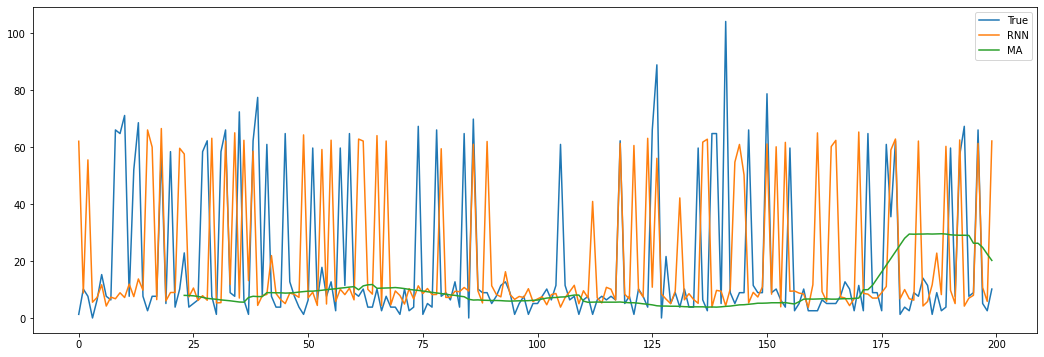

In [22]:
# RNN/Moving Average의 예측 결과 비교
rnn_df = pd.DataFrame()
rnn_df['True'] = trues[:200]
rnn_df['RNN'] = rnn_preds[:200]
rnn_df['MA'] = ma_preds[:200]

rnn_df.plot(figsize=(18, 6))

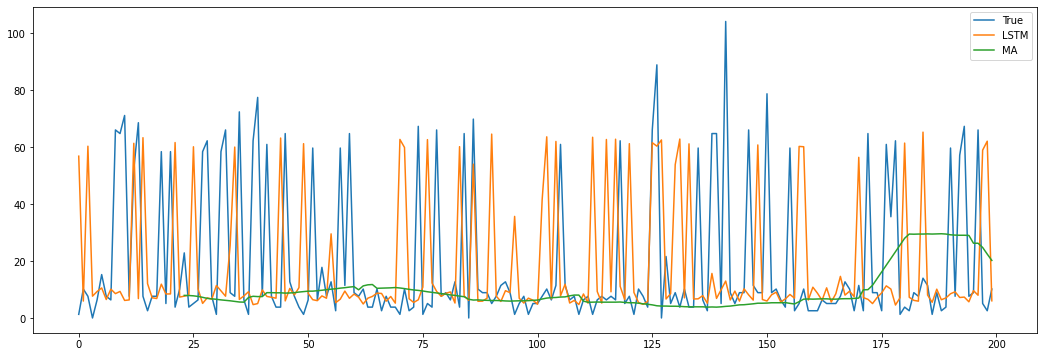

In [23]:
# LSTM/Moving Average의 예측 결과 비교
lstm_df = pd.DataFrame()
lstm_df['True'] = trues[:200]
lstm_df['LSTM'] = lstm_preds[:200]
lstm_df['MA'] = ma_preds[:200]

lstm_df.plot(figsize=(18, 6))

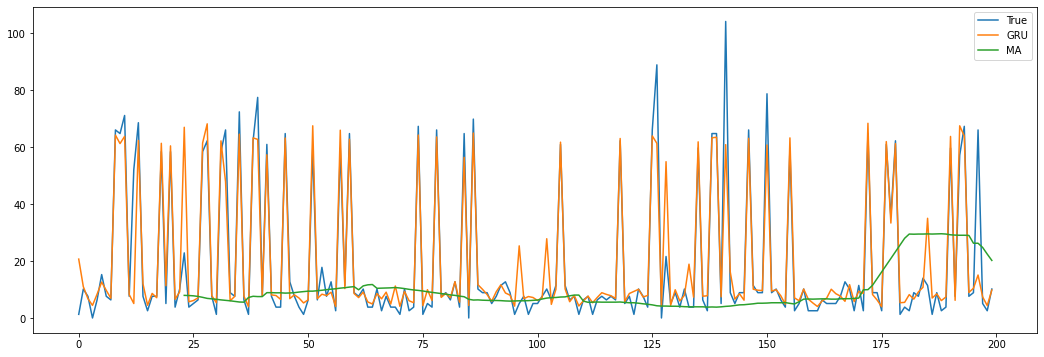

In [24]:
# GRU/Moving Average의 예측 결과 비교
# GRU가 RNN/LSTM 보다 시계열 데이터의 흐름을 더 잘 예측하는 것을 확인할 수 있음
gru_df = pd.DataFrame()
gru_df['True'] = trues[:200]
gru_df['GRU'] = gru_preds[:200]
gru_df['MA'] = ma_preds[:200]

gru_df.plot(figsize=(18, 6))

---